<a href="https://colab.research.google.com/github/quanvu0996/compet/blob/master/kalapa_4student_final_try2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, DenseFeatures, Dropout, BatchNormalization, Embedding
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC, Precision, Recall
import tensorflow.keras.backend as K
from tensorflow import feature_column as fc
from keras.wrappers.scikit_learn import KerasRegressor

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc, confusion_matrix
from sklearn.utils import check_random_state
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

import xgboost as xgb
from lightgbm import LGBMClassifier

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
print(pd.__version__)
print(tf.__version__)

1.0.5
2.3.0


In [4]:
submision_path = '/content/drive/My Drive/Data/colabs_data/kalapa_4students/simple_submission.csv'
train_path = '/content/drive/My Drive/Data/colabs_data/kalapa_4students/train.csv'
test_path = '/content/drive/My Drive/Data/colabs_data/kalapa_4students/test.csv'

added_data_path= '/content/drive/My Drive/Data/colabs_data/kalapa_4students/exdata.txt'

**Load và clean dữ liệu**

In [5]:
def load_data(train_path, test_path, label_col = 'label'):
    train_data = pd.read_csv(train_path)
    predict_data = pd.read_csv(test_path)
    return train_data, predict_data

train_data, predict_data = load_data( train_path, test_path )
train_data = train_data[train_data['label'].isin( [0,1] )]
cols = train_data.columns

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (35,43) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (34,42) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [6]:
added_data = pd.read_csv(added_data_path, sep='\t', encoding='utf-8', names = ['homeTownState', 'area', 'population', 'pop_density'])

Clean data

In [7]:
vals_homeTownState = { 'Hanoi' : 'Hà Nội' , 'Ho Chi Minh City' : 'TP.Hồ Chí Minh' , 'Thanh Hóa Province' : 'Thanh Hoá' , 'Nghệ An Province' : 'Nghệ An' , 'Đồng Nai Province' : 'Đồng Nai' , 'Haiphong' : 'Hải Phòng' , 
'Khánh Hòa Province' : 'Khánh Hoà' , 'Thái Bình Province' : 'Thái Bình' , 'Bắc Giang Province' : 'Bắc Giang' , 'Hà Tĩnh Province' : 'Hà Tĩnh' , 'Bình Định Province' : 'Bình Định' , 'Nam Định Province' : 'Nam Định' , 'Bắc Ninh Province' : 'Bắc Ninh' , 'Quảng Ngãi Province' : 'Quảng Ngãi' , 'Hải Dương Province' : 'Hải Dương' , 'Quảng Nam Province' : 'Quảng Nam' , 
'Thái Nguyên Province' : 'Thái Nguyên' , 'An Giang Province' : 'An Giang' , 'Cần Thơ' : 'Cần Thơ' , 'Đắk Lắk Province' : 'Đắk Lắk' , 'Da Nang' : 'Đà Nẵng' , 'Tiền Giang Province' : 'Tiền Giang' , 'Phú Thọ Province' : 'Phú Thọ' , 'Quảng Ninh Province' : 'Quảng Ninh' , 'Ninh Bình Province' : 'Ninh Bình' , 'Thừa Thiên–Huế Province' : 'Thừa Thiên Huế' , 'Bến Tre Province' : 'Bến Tre' , 'Hưng Yên Province' : 'Hưng Yên' , 'Bà Rịa–Vũng Tàu Province' : 'Bà Rịa - Vũng Tàu' , 
'Kiên Giang Province' : 'Kiên Giang' , 'Quảng Trị Province' : 'Quảng Trị' , 'Đồng Tháp Province' : 'Đồng Tháp' , 'Tây Ninh Province' : 'Tây Ninh' , 'Sóc Trăng Province' : 'Sóc Trăng' , 'Lâm Đồng Province' : 'Lâm Đồng' , 'Lạng Sơn Province' : 'Lạng Sơn' , 'Bình Thuận Province' : 'Bình Thuận' , 'Gia Lai Province' : 'Gia Lai' , 'Sơn La Province' : 'Sơn La' , 'Cà Mau Province' : 'Cà Mau' , 'Tuyên Quang Province' : 'Tuyên Quang' , 
'Quảng Bình Province' : 'Quảng Bình' , 'Vĩnh Long Province' : 'Vĩnh Long' , 'Long An Province' : 'Long An' , 'Yên Bái Province' : 'Yên Bái' , 'Bạc Liêu Province' : 'Bạc Liêu' , 'Hòa Bình Province' : 'Hoà Bình' , 'Trà Vinh Province' : 'Trà Vinh' , 'Bình Dương Province' : 'Bình Dương' , 'Phú Yên Province' : 'Phú Yên' , 'Hà Nam Province' : 'Hà Nam' , 
'Vĩnh Phúc Province' : 'Vĩnh Phúc' , 'Lào Cai Province' : 'Lào Cai' , 'Điện Biên Province' : 'Điện Biên' , 'Ninh Thuận Province' : 'Ninh Thuận' , 'Cao Bằng Province' : 'Cao Bằng' , 'Hà Giang Province' : 'Hà Giang' , 
'Bắc Kạn Province' : 'Bắc Kạn' , 'Kon Tum Province' : 'Kon Tum' , 'Hậu Giang Province' : 'Hậu Giang' , 'Sarawak' : 'Sarawak' , 'Đắk Nông Province' : 'Đắk Nông' , 'Seoul' : 'Seoul' , 'Bình Phước Province' : 'Bình Phước' , 'New York' : 'New York' , 'England' : 'England' , 
'Lai Châu Province' : 'Lai Châu' , 'California' : 'California' , 'Hong Kong' : 'Hong Kong' , 'Orientale' : 'Orientale' , 'Dubai' : 'Dubai' , 'Guangdong' : 'Guangdong' , 'Île-de-France' : 'Île-de-France' }

In [8]:
def clean_fn(df_):
  df = df_.copy()

  df = df.replace('notfound','missing')
  df['homeTownState'] = df['homeTownState'].fillna('other').map(vals_homeTownState ).fillna('Foreign')
  df = df.merge(added_data, how = 'left', on = 'homeTownState')
  df[[ 'area', 'population', 'pop_density']] = df[[ 'area', 'population', 'pop_density']].astype('float64')
  
  df["subscriberCount"].replace(0, np.nan, inplace=True)
  df["friendCount"].replace(0, np.nan, inplace=True)
  df["Field_13"] = df["Field_13"].apply(lambda x: 1 if x == x else 0)
  df["Field_38"] = df["Field_38"].map({0: 0.0, 1: 1.0, "DN": np.nan, "TN": np.nan, "GD": np.nan})
  df["Field_62"] = df["Field_62"].map({"I": 1, "II": 2, "III": 3, "IV": 4, "V": 5, "Ngoài quốc doanh Quận 7": np.nan})
  df["Field_47"] = df["Field_47"].map({"Zezo": 0, "One": 1, "Two": 2, "Three": 3, "Four": 4})
  df["Field_27"] = df["Field_27"].replace({0.0: np.nan})
  df["Field_28"] = df["Field_28"].replace({0.0: np.nan})


  df['Field_45_Q'] = df['Field_45'].str[:-3].astype('category')
  df['Field_45_TP_55'] = df['Field_45'].str[:2] == df['Field_55']
  df['is_homeTown_diaChi'] = df['homeTownCity'] == df['diaChi']
  df['is_homeTown_current_city'] = df['homeTownCity'] == df['currentLocationCity']
  df['is_homeTown_current_state'] = df['homeTownState'] == df['currentLocationState']
  df['F48_49'] = df['Field_48'] == df['Field_49']

  df[["Field_27", "Field_28"]].replace(0.0, np.nan, inplace=True)
  df['F18_isnumeric'] = df['Field_18'].str.isnumeric()
  df['F18_isalpha'] = df['Field_18'].str.isalpha()

  return df

train_data = clean_fn(train_data)
predict_data = clean_fn(predict_data)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [9]:
len(train_data.columns)

206

**Phân loại nhóm dữ liệu tương ứng với hướng xử lý**

In [10]:
# Nhãn
cols_label = ['label']
# Đặc trưng binary
cols_fts_binary = [i for i in train_data.select_dtypes(include=['float64','int64']).columns 
                   if len(set(train_data[i].fillna(0)) - {0,1} ) == 0 and i not in cols_label]
# định dang datte yyyy-mm-dd
cols_date = ['Field_1','Field_2','Field_5','Field_6','Field_7','Field_8','Field_9','Field_11'
             ,'Field_15','Field_25','Field_32','Field_33','Field_35','Field_40','Field_43','Field_44'
             ,'F_startDate','F_endDate','E_startDate','E_endDate','C_startDate','C_endDate','G_startDate','G_endDate'
             ,'A_startDate','A_endDate']
# định dạng date yyymmdd
cols_date2 = ['ngaySinh', 'Field_34']
# Đặc trưng dạng văn bản
cols_docs = ['Field_46','diaChi','Field_48','Field_49','currentLocationName','homeTownName','Field_56']
# Định danh bản ghi
cols_id = ['id','Field_45'] +[i for i in train_data.select_dtypes(include = ['object']).columns 
                              if len(train_data[i].unique()) >=350 and i not in cols_date + cols_date2+cols_docs]
# Đặc trưng dạng categorical
cols_categorical = [i for i in train_data.select_dtypes(include = ['object']).columns
                    if i not in cols_id + cols_label+cols_date2+cols_date+cols_docs]
# Đặc trưng số
cols_fts_num = [ i for i in predict_data.select_dtypes(include=['float64','int64']).columns 
                if i not in cols_id + cols_label + cols_fts_binary + cols_date2+cols_date+cols_docs]

In [11]:
# Đặc trưng số có dạng như categorical
cols_num_like_cat = [i for i in cols_fts_num if len(train_data[i].unique()) <= 15 ]
# Đặc trưng số đã kiểm chứng
cols_num = [i for i in cols_fts_num if i not in cols_num_like_cat]

# cols_categorical = list(set(cols_categorical + cols_num_like_cat)) # Không cần thiết, convert qua lại ordinalencoder
cols_fts_num = [i for i in cols_fts_num if i not in cols_num_like_cat ]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train_data
                                                   ,train_data['label'].values
                                                   ,stratify = train_data['label'].values 
                                                   ,test_size = 0.2
                                                   )

In [13]:
X_train.shape

(42424, 206)

In [14]:
# OneHotEncoder(handle_unknown='ignore').fit(X_train[cols_categorical].astype(str).fillna('ms'))
# X_train[cols_categorical].astype(str).info()


In [15]:
# lấy list value cho ordinalencoder
categories_val = []
for i in cols_categorical:
  categories_val.append(list( 
      pd.concat([train_data[i], predict_data[i]]).fillna('missing').apply(lambda x: str(x)).drop_duplicates( 
  ).sort_values().values) )

Test AUC
AUC:  0.7315307772486612
Gini:  0.46306155449732245


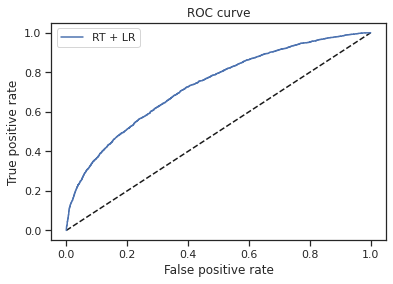

Train AUC
AUC:  0.9729942685580628
Gini:  0.9459885371161256


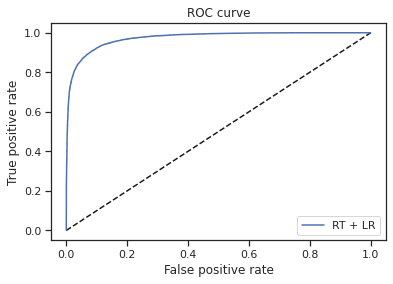

In [18]:
# Xây dựng pipeline và fit với tree-based
selected_columns = cols_categorical+cols_fts_num + cols_date + cols_date2 + cols_fts_binary + cols_num_like_cat #+ cols_docs

class ToString(BaseEstimator, TransformerMixin):
  '''Def 1 trans để convert các cột dạng số như categorical thành dạng cat => dùng được onehot'''
  def fit(self, X, y = None):
    return self
  def transform(self, X, y = None):
    X_ = X.copy() # creating a copy to avoid changes to original dataset
    X_ = X_.astype(str)
    return X_

# Xử lý datetime thành year, month, date như là dạng số - chỉ phù hợp cho tree-based
class DateToNum(BaseEstimator, TransformerMixin):
  def __init__(self, format = '%Y-%m-%d' ):
    self.format = format
  def fit(self, X, y = None):
    return self
  def transform(self, X, y = None):
    X_ = X.copy() # creating a copy to avoid changes to original dataset

    if self.format == '%Y%m%d':
      str_num = 8
    else:
      str_num = 10
    cols = X_.columns
    for i in X.columns:
      X_[i+'year_as_number'] = pd.to_datetime(X_[i].apply(lambda i: str(i)[0:str_num])
                                        , format= self.format , errors= 'coerce').dt.year -2010
      X_[i+'month_as_number'] = pd.to_datetime(X_[i].apply(lambda i: str(i)[0:str_num])
                                        , format= self.format , errors= 'coerce').dt.month
      X_[i+'day_as_number'] = pd.to_datetime(X_[i].apply(lambda i: str(i)[0:str_num])
                                        , format= self.format , errors= 'coerce').dt.day
    X_[cols] = X_[cols].apply(lambda x: ( pd.to_datetime(x.apply(lambda i: str(i)[0:str_num]) , format= self.format , errors= 'coerce')  
                              - pd.to_datetime('20170101', format='%Y%m%d')).apply(lambda x: x.days)
                       , axis = 1)
    return X_

class DocsProcessing(BaseEstimator, TransformerMixin):
  def __init__(self, max_features = None):
    self.max_features_ = max_features
  def fit(self, X, y = None):
    self.X = X.copy()
    try:
      self.X['docs_combine_all_column'] = ''
    except:
      self.X = pd.DataFrame(data= self.X)
      self.X['docs_combine_all_column'] = ''
    for i in self.X.columns:
      self.X['docs_combine_all_column'] += self.X[i]
    self.tokenizer = TfidfVectorizer(max_features = self.max_features_)
    self.tokenizer.fit(self.X['docs_combine_all_column'])
    return self

  def transform(self, X, y = None):
    return self.tokenizer.transform(self.X['docs_combine_all_column']).todense()

# docs_pipe= Pipeline([
#       ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))
#     , ('to_string', ToString())
#     , ('vectorize', DocsProcessing(max_features = 512))
# ])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))
    , ('to_string', ToString())
    , ('encode', OrdinalEncoder(categories=categories_val))
])

ordinal_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value= -1 ))
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
    , ('standard', StandardScaler()) # Với tree thì không cần standard
])

binary_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value= -1 ))
    , ('standard', StandardScaler()) # Với tree thì không cần standard
])

datetime_pipe1 = Pipeline([
    ('datetime1', DateToNum(format='%Y-%m-%d'))
    , ('standard', StandardScaler()) # Với tree thì không cần standard
    , ('imputer', SimpleImputer(strategy='median'))
])

datetime_pipe2 = Pipeline([
    ('datetime2', DateToNum(format='%Y%m%d'))
    , ('standard', StandardScaler()) # Với tree thì không cần standard
    , ('imputer', SimpleImputer(strategy='median'))
])

preprocessing = ColumnTransformer(
    [
    #  ('docs', docs_pipe, cols_docs),
     ('cat', categorical_pipe, cols_categorical),
     ('ordinal', ordinal_pipe, cols_num_like_cat),
     ('num', numerical_pipe, cols_fts_num), 
     ('binary', binary_pipe, cols_fts_binary), 
     ('date1', datetime_pipe1, cols_date),
     ('date2', datetime_pipe2, cols_date2)
     ])

#xgb.XGBRegressor(objective="reg:linear", random_state=42, n_estimators =64, max_depth =7)

model = LGBMClassifier(
            nthread=4,
            n_estimators=1000,
            learning_rate=0.02,
            num_leaves=128,
            colsample_bytree=0.9497036,
            subsample=0.5,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1
        )

pipe = Pipeline([
    ('preprocess', preprocessing),
    # ('pca', PCA(n_components = 150)),
    ('classifier', model)
])

pipe.fit(X_train[selected_columns], y_train)

def evaluate_model(model, X, y):
  try:
    y_pred = model.predict_proba(X)[:, 1]
  except:
    y_pred = model.predict(X)

  fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y, y_pred)
  auc_s = auc(fpr_rt_lm, tpr_rt_lm)
  print('AUC: ', auc_s)
  print('Gini: ', 2*auc_s - 1)

  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()
print('Test AUC')
evaluate_model(pipe, X_test[selected_columns], y_test)

print('Train AUC')
evaluate_model(pipe, X_train[selected_columns], y_train)


Dự đoán kết quả

In [ ]:
try:
  prediction = pipe.predict_proba(predict_data[selected_columns])[:, 1]
except:
  prediction = pipe.predict(predict_data[selected_columns])
res_df = pd.DataFrame({'id': predict_data.id, 'label': prediction})
res_df.to_csv('submission.csv', index=False)

In [ ]:
predict_